In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6041
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0682e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7046e-04
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4949e-04
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2337e-04
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9278e-04
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4811e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4532e-04 
Test Loss: 0.00038375204894691706
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Root Mean Squared Error (RMSE): 0.01958959145911368


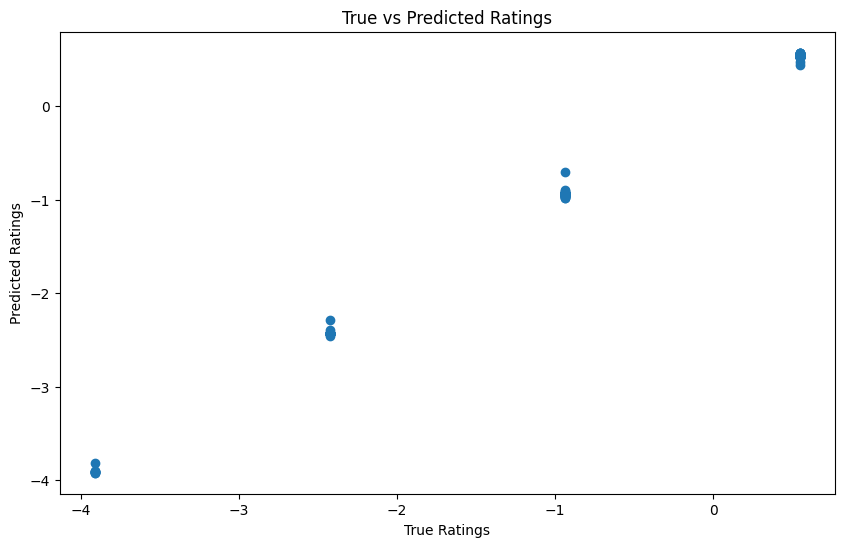

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                  product_name  predicted_ratings
1458         Realme 9 Pro Plus           0.579023
1465  Realme GT Master Edition           0.578578
182      Samsung Galaxy A53 5G           0.576258
1617            itel Value 110           0.573046
1610         E-Tachi B222 lite           0.572825
1673        Xiaomi Pad 5 Cover           0.572382
1508      Realme Dizo Star 300           0.571939
1653         Apple iPad mini 6           0.570744
1631            itel Muzik 410           0.570719
1632            itel Power 700           0.570603


In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Update the dataset path
dataset_path = '/content/drive/MyDrive/E-Commerce Tech Dataset/Dataset(Shophive HomeShopping PriceOye).csv'

# Load the dataset
df = pd.read_csv(dataset_path)

# Data Cleaning

# Cleaning product_price column: removing 'Rs.', commas, and handling missing values
def clean_price(price):
    price = re.sub(r'<.*?>', '', str(price))  # Remove HTML tags
    price = price.replace('Rs.', '').replace(',', '').strip()  # Remove Rs. and commas
    try:
        return float(price)
    except ValueError:
        return np.nan  # Return NaN if conversion fails

df['product_price'] = df['product_price'].apply(clean_price)

# Cleaning rating_count column: converting "x Ratings" format to integers
def clean_rating_count(rating_count):
    try:
        return int(rating_count.split()[0])  # Extract the number before 'Ratings'
    except (ValueError, AttributeError):
        return np.nan  # Return NaN if conversion fails

df['rating_count'] = df['rating_count'].apply(clean_rating_count)

# Dropping rows with missing values in key columns
df = df.dropna(subset=['product_price', 'product_ratings', 'rating_count'])

# Normalizing numerical features: product_price, product_ratings, and rating_count
scaler = StandardScaler()
features = ['product_price', 'product_ratings', 'rating_count']
df[features] = scaler.fit_transform(df[features])

# Splitting the data into features (X) and target (y)
X = df[features].values  # Features: normalized price, ratings, and count
y = df['product_ratings'].values  # Target: product ratings

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to TensorFlow dataset for deep learning
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).repeat()
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Define a neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
steps_per_epoch = len(X_train) // 32  # Define steps per epoch
model.fit(train_data, steps_per_epoch=steps_per_epoch, epochs=10)

# Evaluate the model
test_loss = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")

# Predicting values and calculating RMSE
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualizing the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.show()

# Recommendation example: recommend top N products for a user
def recommend_top_n(top_n=10):
    all_products = df[['product_name', 'product_price', 'product_ratings', 'rating_count']].copy()
    all_products['predicted_ratings'] = model.predict(all_products[features].values)
    recommendations = all_products.sort_values(by='predicted_ratings', ascending=False).head(top_n)
    return recommendations[['product_name', 'predicted_ratings']]

# Example: Recommend top 10 products
top_10_recommendations = recommend_top_n(top_n=10)
print(top_10_recommendations)

# Save recommendations to Google Drive
top_10_recommendations.to_csv('/content/drive/MyDrive/E-Commerce Tech Dataset/Dataset(Shophive HomeShopping PriceOye).csv', index=False)
